In [9]:
%load_ext ipycache
%load_ext autoreload
%autoreload 2

# from pyinstrument import Profiler

The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initialization
## Hyperparameters for discovery

In [10]:
import sys
sys.path.insert(0, '../../../')
from src.discoverers.adsorption.values import calc_co2rr_activities


adsorbate = 'CO'
initial_training_size = 1000
batch_size = 200
quantile_cutoff = 0.95
target = -0.67  # eV

## Gather validation data

In [11]:
import random
import ase.db


db_dir = '../../pull_data/%s/' % adsorbate
db = ase.db.connect(db_dir + '%s.db' % adsorbate)
rows = list(db.select())
random.Random(42).shuffle(rows)


def parse_rows(rows):
    features = []
    labels = []
    surfaces = []

    for row in rows:
        features.append(row.id)
        data = row.data
        labels.append(data['adsorption_energy'])
        surface = (data['mpid'], data['miller'], data['shift'], data['top'])
        surfaces.append(surface)

    return features, labels, surfaces


training_features, training_labels, training_surfaces = parse_rows(rows[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_rows(rows[initial_training_size:])

# Hallucinate
## Initialize

In [12]:
from src.discoverers.adsorption.models import PrimeModel


model = PrimeModel(db_dir)

In [13]:
from src.discoverers.adsorption.randomsearch import RandomSearcher


discoverer = RandomSearcher(model=model,
                            quantile_cutoff=quantile_cutoff,
                            value_calculator=calc_co2rr_activities,
                            batch_size=batch_size,
                            training_features=training_features,
                            training_labels=training_labels,
                            training_surfaces=training_surfaces,
                            sampling_features=sampling_features,
                            sampling_labels=sampling_labels,
                            sampling_surfaces=sampling_surfaces,
                            #n_samples=3,  # decrease to speed up
                            init_train=False  # Set to `False` only for warm starts
                            )

## Run

In [14]:
# Or load the last run
discoverer.load_last_run()

## Analyze

../../../src/discoverers/base.py:426: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  _ = ax.set_ylim([0., np.nanmax(rolled_values) * 1.1])


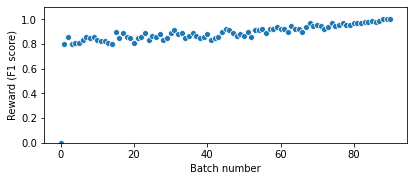

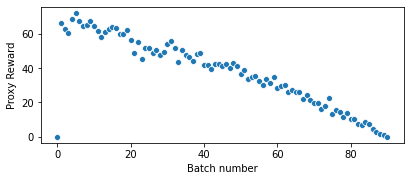

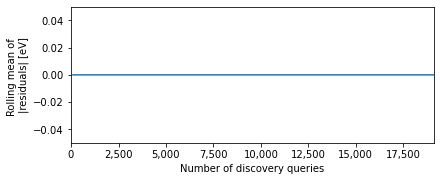

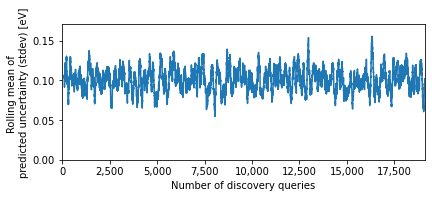

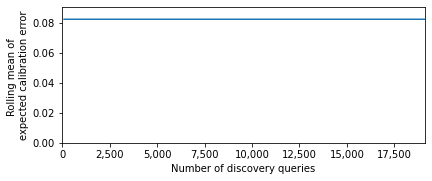

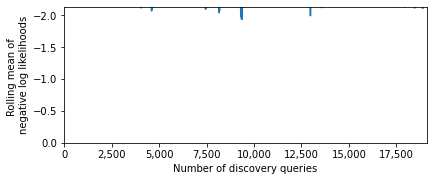

In [15]:
reward_fig, proxy_fig, accuracy_fig, uncertainty_fig, calibration_fig, nll_fig = discoverer.plot_performance(window=100)